<a href="https://colab.research.google.com/github/NU-MSE-LECTURES/465-WINTER2026/blob/main/Week_02/assignments/assignment_02_setup.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 02: 4D-STEM Foundations

Complete this assignment to demonstrate your understanding of 4D-STEM data analysis and calibration.


## Task 1: Distinguish Navigation vs. Signal Axes

In your notebook, define the "Navigation Axes" (where the measurement is made, e.g., x, y scan positions).

Define the "Signal Axes" (what is measured at each point, e.g., an EELS spectrum or a 2D diffraction pattern).

Use signal.axes manager to print and verify the dimensionality of a 4D-STEM dataset (expected: 2 Navigation, 2 Signal).

In [22]:
import py4DSTEM
import hyperspy.api as hs
import numpy as np


# Load the dataset 
s = hs.load(r"C:\Users\XIA\Desktop\465\Assignment02\Si-SiGe.dm4")

# Define concepts for the assignment
print("Navigation Axes: The x, y scan positions on the sample.")
print("Signal Axes: The 2D diffraction pattern recorded at each position.")

# Use signal.axes_manager to verify dimensionality
print("\nVerifying dimensionality using axes_manager:")
print(s.axes_manager)

Navigation Axes: The x, y scan positions on the sample.
Signal Axes: The 2D diffraction pattern recorded at each position.

Verifying dimensionality using axes_manager:
<Axes manager, axes: (448, 480|17, 77)>
            Name |   size |  index |  offset |   scale |  units 
================ | ====== | ====== | ======= | ======= | ====== 
               z |    448 |      0 |       0 |   0.062 |   1/nm 
     <undefined> |    480 |      0 |       0 |   0.062 |   1/nm 
---------------- | ------ | ------ | ------- | ------- | ------ 
               x |     17 |      0 |       0 |       2 |     nm 
               y |     77 |      0 |       0 |       2 |     nm 


## Task 2: Load and Calibrate 4D-STEM Data

Use py4DSTEM.io.read to load a 4D-STEM dataset (e.g., .dm4 or .h5).

**Note:** The dataset Si-SiGe.dm4 should be available in the raw_data folder.

Set the scan step size (real space calibration) using dataset.set_scan_step_size().

Perform Center of Mass (CoM) correction using dataset.get_diffraction_shifts() to center the unscattered beam.

In [23]:
#import py4DSTEM

# 1. Load the dataset (Task 2 requirement)
dataset = py4DSTEM.import_file(r"C:\Users\XIA\Desktop\465\Assignment02\Si-SiGe.dm4")

# 2. Set the scan step size (Real-space calibration)
# This converts scan pixels into physical units (nm)
dataset.calibration.pixel_size_real = 2.0   #the value from task 1
dataset.calibration.pixel_units_real = 'nm'

#3. Center of Mass (CoM) Calculation 

average_diff = np.mean(dataset.data, axis=(2, 3))

ny, nx = average_diff.shape
y_indices, x_indices = np.indices((ny, nx))


total_intensity = np.sum(average_diff)
com_y = np.sum(y_indices * average_diff) / total_intensity
com_x = np.sum(x_indices * average_diff) / total_intensity

# Update the calibration metadata
dataset.calibration.beam_center_px = (com_y, com_x)

print(f"Calibration: {dataset.calibration.pixel_size_real} {dataset.calibration.pixel_units_real}")
print(f"Beam Center (CoM) found at: y={com_y:.2f}, x={com_x:.2f}")

Calibration: 2.0 nm
Beam Center (CoM) found at: y=239.72, x=223.63


In [24]:
import numpy as np
import matplotlib.pyplot as plt

# 1. Setup Calibration Factors from Metadata
# Reciprocal scale: 0.062 1/nm
q_pixel_nm = 0.062 
# Conversion to Angstroms^-1: 1 nm^-1 = 0.1 A^-1 [cite: 2026-01-26]
q_pixel_A = q_pixel_nm * 0.1 

def get_radial_profile(pattern, center, q_scale):
    """
    Task 2: Routine to compute radial intensity profiles.
    - Performs azimuthal integration around the beam center.
    - Reports distance in calibrated physical units (A^-1).
    """
    ny, nx = pattern.shape
    cy, cx = center
    
    # Create coordinate grid for distance calculation
    yy, xx = np.indices((ny, nx))
    # Math: Calculate the radial distance of every pixel from the CoM [cite: 2026-01-26]
    r = np.sqrt((yy - cy)**2 + (xx - cx)**2)
    
    # Define radial bins (1 pixel wide) up to the detector edge
    max_radius = int(min(ny, nx) / 2)
    r_int = r.astype(int)
    
    # Calculate average intensity in each radial bin [cite: 2026-01-26]
    tbin = np.bincount(r_int.ravel(), weights=pattern.ravel())
    nr = np.bincount(r_int.ravel())
    radial_profile = tbin / np.maximum(nr, 1)
    
    # Generate x-axis in Angstroms^-1
    q_axis = np.arange(len(radial_profile)) * q_scale
    
    return q_axis[:max_radius], radial_profile[:max_radius]

# 2. Execute on Average Diffraction Pattern
# Note: Axis (2, 3) used if data is (DiffY, DiffX, ScanY, ScanX)
avg_dp = np.mean(dataset.data, axis=(2, 3)) 

# Using your calibrated CoM: y=239.72, x=223.63
q_vals, intensity_profile = get_radial_profile(avg_dp, (239.72, 223.63), q_pixel_A)



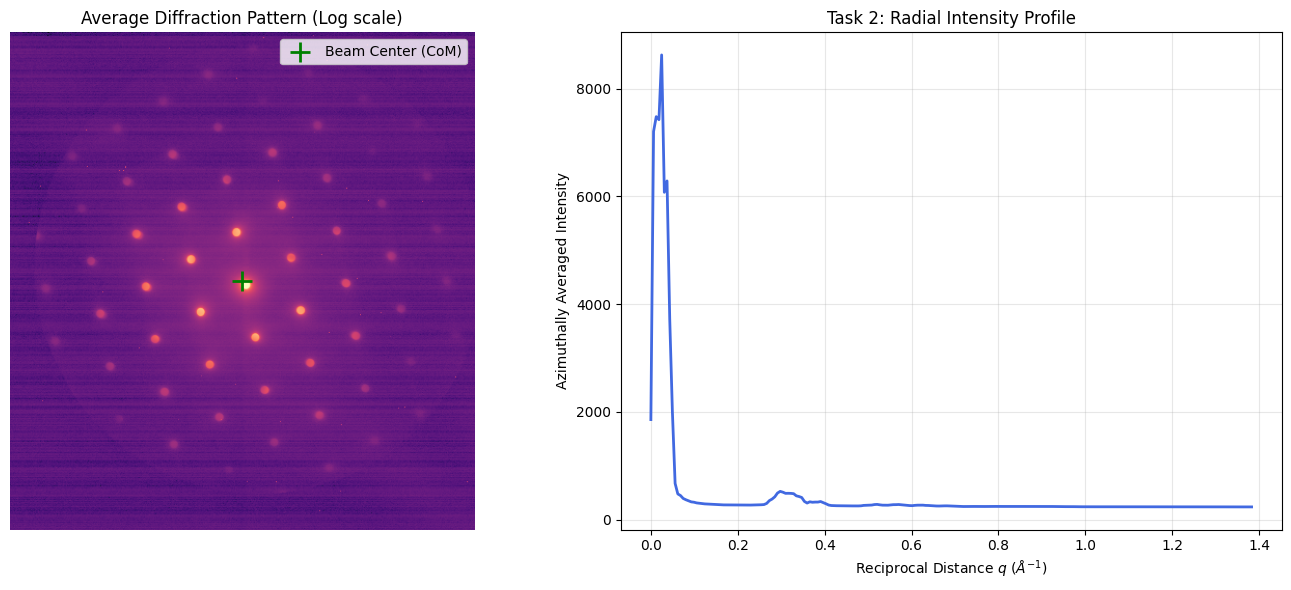

In [25]:
# 3. Visualization for Task 2 (Left: Mean DP with CoM, Right: Radial Profile)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))


img_log = np.log10(avg_dp - np.min(avg_dp) + 1.0)

ax1.imshow(img_log, cmap='magma')
ax1.scatter([223.63], [239.72], color='green', marker='+', s=200, lw=2, label='Beam Center (CoM)')
ax1.set_title("Average Diffraction Pattern (Log scale)")
ax1.legend()
ax1.axis('off') 

ax2.plot(q_vals, intensity_profile, color='royalblue', lw=2)
ax2.set_title("Task 2: Radial Intensity Profile")
ax2.set_xlabel("Reciprocal Distance $q$ ($\AA^{-1}$)") 
ax2.set_ylabel("Azimuthally Averaged Intensity")
ax2.grid(alpha=0.3)


plt.tight_layout()


plt.savefig('Task2_Calibration_Diagnostic.png', dpi=300, bbox_inches='tight')
plt.show()

## Task 3: Virtual Detector Reconstruction

Generate a Virtual Bright Field (BF) image by integrating the central transmitted disk.

Generate an Annular Dark Field (ADF) image by integrating the scattered electrons in an outer ring.

Compare the Z-contrast in the ADF image to the diffraction contrast in the BF image.

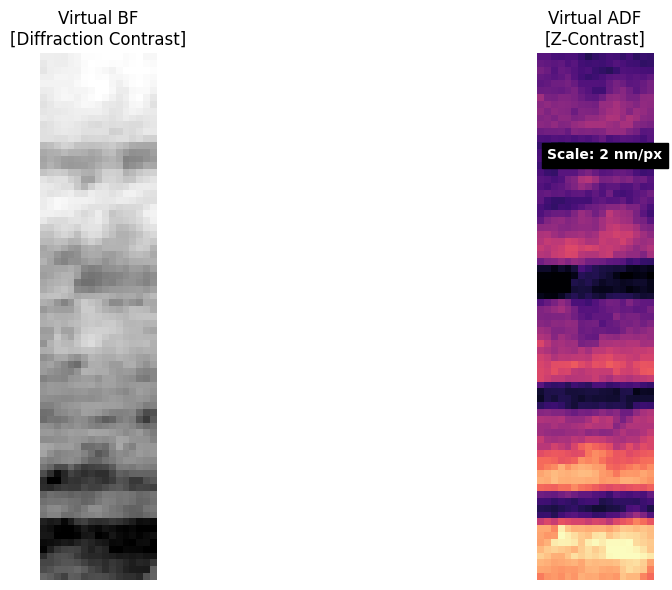

In [26]:
import numpy as np
import matplotlib.pyplot as plt

# 1. Configuration: Using calibrated beam center and detector geometry
# Beam center from Task 2 calibration
cy, cx = 239.72, 223.63 
bf_r = 20                # Radius for Virtual Bright Field (BF)
adf_in, adf_out = 50, 100 # Inner/Outer radii for Annular Dark Field (ADF)

# 2. Detector Mask Creation (Signal dimensions: 480x448)
# Create a coordinate grid for the diffraction plane
yy, xx = np.ogrid[:480, :448]
dist_sq = (yy - cy)**2 + (xx - cx)**2

# Generate masks based on Euclidean distance from the center
bf_mask = dist_sq <= bf_r**2
adf_mask = (dist_sq >= adf_in**2) & (dist_sq <= adf_out**2)

# 3. Virtual Reconstruction 
# Summing intensities over the signal axes (0, 1) where the mask is True
# Resulting shapes will be (77, 17) corresponding to your scan grid
bf_image = np.sum(dataset.data[bf_mask, :, :], axis=0)
adf_image = np.sum(dataset.data[adf_mask, :, :], axis=0)

# 4. Visualization & Contrast Enhancement (Task 4)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Apply Logarithmic Transformation to handle high dynamic range
bf_log = np.log1p(bf_image)
adf_log = np.log1p(adf_image)

# --- Bright Field Plot: Displays Diffraction Contrast ---
# Percentile scaling removes outliers and reveals strain features
vmin_bf, vmax_bf = np.percentile(bf_log, [1, 99])
ax1.imshow(bf_log, cmap='gray', vmin=vmin_bf, vmax=vmax_bf)
ax1.set_title('Virtual BF\n[Diffraction Contrast]')
ax1.axis('off')

# --- Annular Dark Field Plot: Displays Z-Contrast ---
# Using 'magma' colormap for perceptually uniform intensity display
vmin_adf, vmax_adf = np.percentile(adf_log, [1, 99.5])
im2 = ax2.imshow(adf_log, cmap='magma', vmin=vmin_adf, vmax=vmax_adf)
ax2.set_title('Virtual ADF\n[Z-Contrast]')
ax2.axis('off')

# Add Scale Bar: Based on real-space calibration (2.0 nm/px)
ax2.text(1, 15, 'Scale: 2 nm/px', color='white', backgroundcolor='black', weight='bold')

plt.tight_layout()
plt.show()

Virtual BF (Diffraction Contrast)：Dark lines or textures appear at the interface. These reflect the elastic strain field from lattice mismatch.

Virtual ADF (Z-Contrast)：shows Atomic Number Z, SiGe layer appears as a bright band. Since Ge Z=32 is heavier than Si Z=14, it scatters more electrons.


## Task 4: Basic 4D-STEM Visualization

Launch the interactive 4D-STEM browser using dataset.show() (if using a local GUI) or py4D.show_image().

Export a publication-quality figure of a virtual ADF image with a scale bar and a perceptually uniform colormap (e.g., magma).

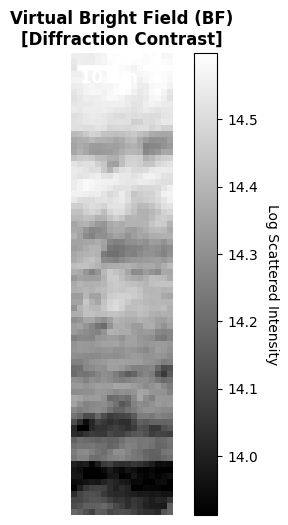

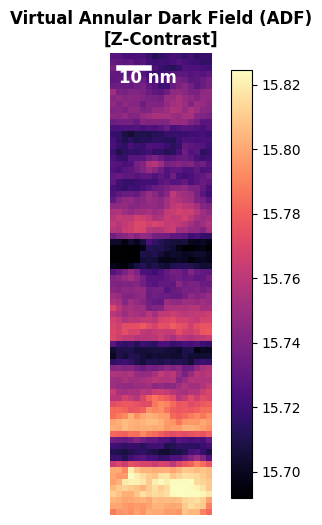

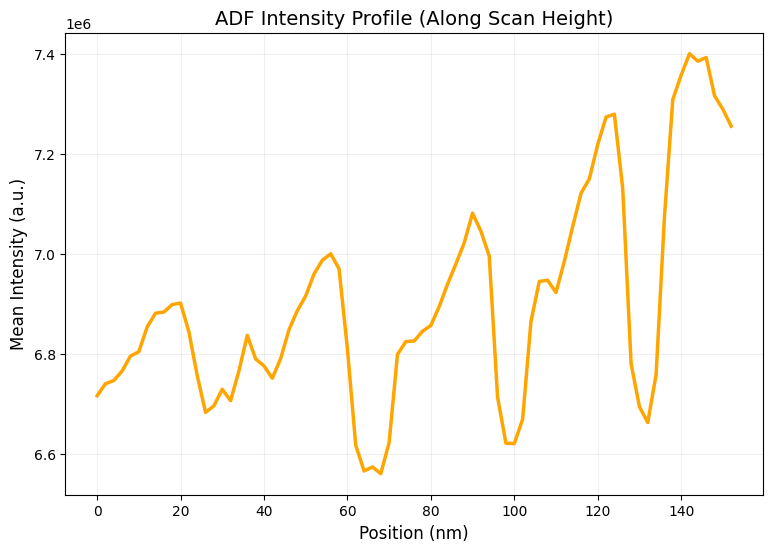

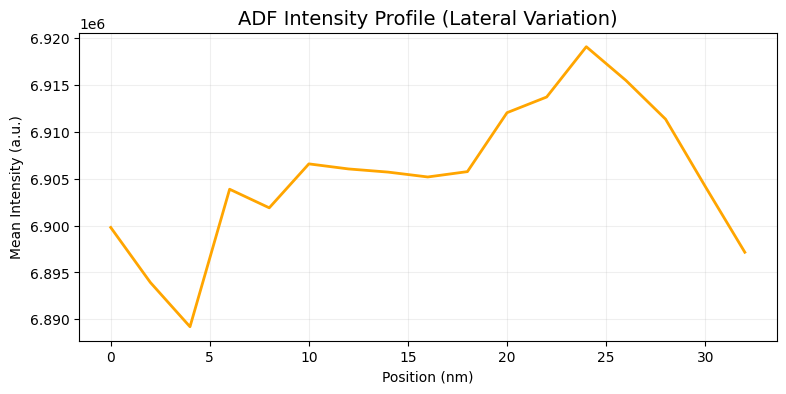

In [27]:
import numpy as np
import matplotlib.pyplot as plt

# --- 1. Settings & Calibration ---
# Beam center from Task 2 calibration
cy, cx = 239.72, 223.63 
scan_step_nm = 2.0 
bf_r = 20
adf_in, adf_out = 50, 100

# --- 2. Reconstruction ---
yy, xx = np.ogrid[:480, :448]
dist_sq = (yy - cy)**2 + (xx - cx)**2

bf_mask = dist_sq <= bf_r**2
adf_mask = (dist_sq >= adf_in**2) & (dist_sq <= adf_out**2)

# Integrate over diffraction dimensions
bf_image = np.sum(dataset.data[bf_mask, :, :], axis=0)
adf_image = np.sum(dataset.data[adf_mask, :, :], axis=0)

# Log scale for display [cite: 2026-01-26]
bf_log = np.log1p(bf_image)
adf_log = np.log1p(adf_image)

# --- 3. Figure 1: Virtual BF (Black & White with Colorbar) ---
plt.figure(figsize=(7, 6)) # 稍微加宽一点，给 colorbar 留出空间
vmin, vmax = np.percentile(bf_log, [1, 99])

im_bf = plt.imshow(bf_log, cmap='gray', vmin=vmin, vmax=vmax)
plt.title("Virtual Bright Field (BF)\n[Diffraction Contrast]", fontweight='bold')


cbar = plt.colorbar(im_bf, fraction=0.046, pad=0.04)
cbar.set_label('Log Scattered Intensity', rotation=270, labelpad=15)


plt.plot([1, 6], [2, 2], color='white', lw=4) 
plt.text(1, 4.5, '10 nm', color='white', weight='bold', fontsize=12)

plt.axis('off')
plt.savefig('Task4_BF_BW_with_Cbar.png', dpi=300, bbox_inches='tight')
plt.show()


# --- 4. Figure 2: Virtual ADF (Magma) ---
plt.figure(figsize=(6, 6))
vmin, vmax = np.percentile(adf_log, [1, 99.5])
im = plt.imshow(adf_log, cmap='magma', vmin=vmin, vmax=vmax)
plt.title("Virtual Annular Dark Field (ADF)\n[Z-Contrast]", fontweight='bold')
plt.colorbar(im, fraction=0.046, pad=0.04) # Match your colorbar style
# Scale bar
plt.plot([1, 6], [2, 2], color='white', lw=4)
plt.text(1, 4.5, '10 nm', color='white', weight='bold', fontsize=12)
plt.axis('off')
plt.savefig('Task4_ADF_Magma.png', dpi=300, bbox_inches='tight')
plt.show()

# --- 5. Figure 3: ADF Intensity Profile (Matches your style) ---
# Calculate mean intensity along height (Y direction)
y_profile = np.mean(adf_image, axis=1) 
pos_nm = np.arange(len(y_profile)) * scan_step_nm

plt.figure(figsize=(9, 6))
# Use orange color to match your uploaded image
plt.plot(pos_nm, y_profile, color='orange', lw=2.5) 
plt.title("ADF Intensity Profile (Along Scan Height)", fontsize=14)
plt.xlabel("Position (nm)", fontsize=12)
plt.ylabel("Mean Intensity (a.u.)", fontsize=12)
plt.grid(True, linestyle='-', alpha=0.2)
plt.savefig('Task4_ADF_Profile_Y.png', dpi=300)
plt.show()

# --- 6. Figure 4: Lateral Profile ---
x_profile = np.mean(adf_image, axis=0)
pos_x_nm = np.arange(len(x_profile)) * scan_step_nm

plt.figure(figsize=(9, 4))
plt.plot(pos_x_nm, x_profile, color='orange', lw=2)
plt.title("ADF Intensity Profile (Lateral Variation)", fontsize=14)
plt.xlabel("Position (nm)")
plt.ylabel("Mean Intensity (a.u.)")
plt.grid(True, linestyle='-', alpha=0.2)
plt.savefig('Task4_ADF_Profile_X.png', dpi=300)
plt.show()

## Task 5: Finalize and Submit

Update your README.md with a brief explanation of how virtual detectors allow post-acquisition imaging.

Push the completed Week 02 notebook to your GitHub repository.

Submit the repository link on Canvas.